# Generation of Bottom-Trapped Internal Tides
Conversion from barotropic to baroclinic tide, linear calculation following [Falahat & Nycander, 2015]

* assume cartesian grid with constant spacing dx, dy (fftconvolve)
* uses exponential fit for the stratification, with corresponding approximate solutions for the vertical modes (and associated wavenumber)
* spectral discretization: compute the solutions for different values of $\kappa_n$, then uses linear interpolation
* different data sources: 1 for topo (and reference grid), 1 for tidal components, 1 for stratification
* this version assumes horizontally homogeneous stratification

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap as bm
import scipy.interpolate as itp
import scipy.signal as sig
import scipy.stats as stats
import scipy.special as sp
from netCDF4 import Dataset
import time
from datetime import datetime
from detrend_2d import detrend_2d

from SW_Density import SW_Density as rhop # temporary
#from comp_rho import rhop
from distance_sphere_matproof import dist_sphere_matproof
from convert_TPXO_to_ellipses import get_tpxo8_on_grid
from PyFVCOM import tidal_ellipse as ellipse

doverb = True

In [30]:
# --- data location --- define every paths to read data (topo, tides, stratif)
path_data = '/data0/project/vortex/lahaye/Tide_Conv/input_data/' #'./input_data/' #
path_data = '/net/krypton'+path_data     # if not on LOPS hub
path_alpha = '/net/alpha/exports/sciences/data/REFERENCE_DATA/'

# --- climato ---
clim = "lucky"
if clim == "lucky":
    cname = path_data+"lucky_ts_meanSODA_winter.nc"

# --- topography dataset --- 
topo = "lucky" # "tpxo" # "srtm"
if topo == 'lucky':
    file_topo = path_data+"lucky_corgrd.nc"
    varx, vary = 'lon_rho', 'lat_rho'
    varh = 'h'

# --- tide dataset --- 
tide = 'tpxo8' #'tpxo7' #

if tide == 'lucky':
    uname = path_data+'luckym2_frc.nc' 
elif tide == "tpxo7":
    uname = path_alpha+"TIDES/TPXO7.2/u_tpxo7.2.nc"
    gname = uname.replace("u","grid")
elif tide == 'tpxo8':
    uname = path_alpha+"TIDES/TPXO8/uv.k1_tpxo8_atlas_30c_v1.nc"
    gname = uname.replace("uv.k1","grid")
    
zmin       = -100              # min depth to compute Ef [m], below contin. shelf roughly
g          = 9.81              # gravity [m s-2]
K1         = 2*np.pi/23.93     # K1 tide frequency [rad/hour] 
Erad = 6371e3                  # Earth radius [m]


In [3]:
# ------ get topo on the grid, and grid --------
# load the entire grid (regional modelling purpose)

nc   = Dataset(file_topo,'r') # etopo2 and srtm30 files have the same structure

if topo == 'lucky':
    lon_h = nc.variables[varx][:].T
    lat_h = nc.variables[vary][:].T
    nlon_h, nlat_h = lon_h.shape
    h_t = -nc.variables[varh][:].T
    h_t[h_t>=-2.5] = 0     # land points   # "raw" topo (for FFT)
    h_ma = np.ma.masked_where(h_t==0,-h_t) # masked topo
    dx_h = 1/nc.variables['pm'][:].T
    dy_h = 1/nc.variables['pn'][:].T
    gang = nc.variables['angle'][:].T # grid angle (rad., between xi (origin) and E, pos. cc-wise)
nc.close()

dx, dy = dx_h.mean(),dy_h.mean()
dhdx, dhdy = np.gradient(h_t,dx,dy)
Nx, Ny = h_t.shape

fcor = 2.*(2*np.pi/24.)*np.sin(np.deg2rad(lat_h)) # coriolis, rad/hour

In [4]:
# ------ extract Tides ------------------------------
# output must be complex x- and y- component of barotropic velocity (computation in cartesian coordinates)

if tide == 'lucky':
    raise ValueError("not implemented")
    nc = Dataset(uname,'r')    # all this is old version
    # angle between major axis and east [rad] (beware sign)
    phi = nc.variables['tide_Cangle'][0,...].T
    # tide phase ()
    pha = nc.variables['tide_Cphase'][0,...].T
    # tidal current amplitude (major, minor axes)
    ue = nc.variables['tide_Cmax'][0,...].T
    ve = nc.variables['tide_Cmin'][0,...].T
    nc.close()
    ubt,uphi,vbt,vphi, _ = ellipse.ep2ap(ue,ve/ue,phi+np.rad2deg(phi),pha)  # INC+grang correct ?
    del phi, ue, ve
elif tide == 'tpxo7':
    raise ValueError("not implemented, need to modify get_tpxo7_on_grid before")
elif tide == 'tpxo8':
    ure,uim,vre,vim = get_tpxo8_on_grid([uname,gname],lon_h,lat_h,return_what="comp",grang=gang) 
    ue = ure + 1.j*uim
    ve = vre + 1.j*vim
    del ure, uim, vre, vim


/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:187: RuntimeWarning: invalid value encountered in true_divide
  ure = nc.variables['uRe'][indxu,indyu]*1e-4/hu    # cm²/s to m/s
/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:188: RuntimeWarning: invalid value encountered in true_divide
  vre = nc.variables['vRe'][indxv,indyv]*1e-4/hv
/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:189: RuntimeWarning: invalid value encountered in true_divide
  uim = nc.variables['uIm'][indxu,indyu]*1e-4/hu
/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:190: RuntimeWarning: invalid value encountered in true_divide
  vim = nc.variables['vIm'][indxv,indyv]*1e-4/hv


In [5]:
# ------ extract density profile, compute N2 ------------------
# Also define the function that compute the wavenumber (phase speed)
if clim == "lucky":
    nc = Dataset(cname,'r')
    T = nc.variables['temp_roms_avg'][:]
    S = nc.variables['salt_roms_avg'][:]
    zz = nc.variables['depth'][:]
    nz = zz.size


rho = np.sort(rhop(T,S)) #SW_Density(T,S) # sorting is cheating here
rho0 = rho.mean()
frho = itp.pchip(zz[::-1],rho[::-1],extrapolate=True)
N2_tmp = -(g/rho0)*frho.derivative()(zz)    # take routine
# temporary fixing:
if N2_tmp[-1]==0: N2_tmp[-1] = 1e-8    # this is a dirty fix
indneg, = np.where(N2_tmp<=0.)
for ii in indneg:
    N2_tmp[ii] = (N2_tmp[ii-1] + N2_tmp[ii+1])/2
fN2 = itp.pchip(zz[::-1],N2_tmp,extrapolate=True)

# fit exponential profile: N \approx N0*exp(bz)
slope,intercept,r_val,p_val,std_err = stats.linregress(zz,np.log(N2_tmp**0.5))
N0  = np.exp(intercept)
b   = 1./slope
N2b = np.sqrt(fN2(h_t))

if doverb:
    if indneg.size>0:
        print('had to resort stratif for {} values'.format(indneg.size))
    print('exponential interpolation for stratification: N0={0:.3e}, b={1:.1f}'.format(N0,b))

def cn_expN(n,h,omega,b=b,N0=N0):
    """ 
    approximate (WKBJ) phase speed exponential fit for the stratification 
    of the form N=N0.exp(z/b) with z algebraic depth
    h is bottom depth (absolute value) 
    omega, f: tidal and Coriolis frequencies (rad/s)
    following StLaurent & Garrett 2002"""
    return np.sqrt((N0*b/h*(1-np.exp(-h/b)))**2 - omega**2) * h/n/np.pi


exponential interpolation for stratification: N0=2.967e-03, b=1472.7


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


Lk = 7.56e+02, kernel size (658,658) timing: 5.050186999999994 5.050462961196899
Lk = 3.85e+01, kernel size (32,32) timing: 1.90284699999998 1.9026215076446533
Lk = 1.97e+01, kernel size (16,16) timing: 2.1386909999999943 2.1381452083587646
Lk = 1.33e+01, kernel size (10,10) timing: 1.8134230000000002 1.8134708404541016
Lk = 1.00e+01, kernel size (8,8) timing: 1.8260390000000086 1.8261137008666992


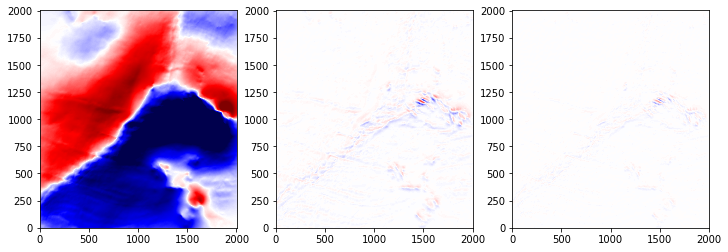

In [13]:
# Test: show solution for pressure for different values of Kn

omega = K1
imod = 1
nks = 5

indox, indoy = np.where(h_ma>-zmin)
trunc = 4.1 # truncature (K0(4.1) = 1/100)

cn = cn_expN(imod,h_ma,omega/3600.)
kn = np.sqrt(fcor**2-omega**2)/cn/3600
kmoy = np.nanmean(kn)
k1 = np.nanmin(kn[h_t<zmin])
k2 = np.nanmax(kn[h_t<zmin])

ks = np.linspace(k1,k2,nks)

udhx, vdhy = ue*dhdx, ve*dhdy
pn = np.zeros((nks,Nx,Ny)) + 0.j

for ik,kk in zip(range(nks),ks):
    nsx = min(int(trunc/kk/dx)//2 * 2, Nx//2)
    nsy = min(int(trunc/kk/dy)//2 * 2, Ny//2)
    xp, yp = np.arange(-nsx+0.5,nsx)*dx, np.arange(-nsy+0.5,nsy)*dy
    rad = np.sqrt(xp[:,None]**2 + yp[None,:]**2)
    kern = sp.kn(0,kk*rad)
    kern[rad*kk > trunc] = 0

    tmes, tmeb = time.clock(), time.time()
    pn[ik,:,:] = sig.fftconvolve(udhx, kern, mode="same") + sig.fftconvolve(vdhy, kern, mode = "same")
    print("Lk = {0:.2e}, kernel size ({1},{2})".format(2*np.pi/kk/1e3,nsx,nsy) \
            , "timing:", time.clock()-tmes, time.time()-tmeb)

iks = (0,1,2)
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].pcolormesh(pn[iks[0],:,:].imag.T,vmin=-2,vmax=2,cmap="seismic")
axs[1].pcolormesh(pn[iks[1],:,:].imag.T,vmin=-2,vmax=2,cmap="seismic")
axs[2].pcolormesh(pn[iks[2],:,:].imag.T,vmin=-2,vmax=2,cmap="seismic")

In [26]:
omega = K1
imod = 1
nks = 100

indox, indoy = np.where(h_ma>-zmin)
trunc = 4.1 # truncature (K0(4.1) = 1/100)

cn = cn_expN(imod,h_ma,omega/3600.)
kn = np.sqrt(fcor**2-omega**2)/cn/3600
kmin = np.nanmin(kn[h_t<zmin])
kmax = np.nanmax(kn[h_t<zmin])
ks = np.linspace(kmin,kmax,nks)
#np.logspace(np.log10(kmin),np.log10(kmax),nks)

udhx, vdhy = ue*dhdx, ve*dhdy
pn = np.zeros((Nx,Ny)) + 0.j

k2 = kmin
nsx = min(int(trunc/kk/dx)//2 * 2, Nx//2)
nsy = min(int(trunc/kk/dy)//2 * 2, Ny//2)
xp, yp = np.arange(-nsx+0.5,nsx)*dx, np.arange(-nsy+0.5,nsy)*dy
rad = np.sqrt(xp[:,None]**2 + yp[None,:]**2)
kern = sp.kn(0,k2*rad)
kern[rad*k2 > trunc] = 0
solb = sig.fftconvolve(udhx, kern, mode="same") + sig.fftconvolve(vdhy, kern, mode = "same")

for ik in range(1,nks):
    k1, k2 = ks[ik-1:ik+1]
    sola = solb.copy()
    mask = np.where( (kn>=k1) & (kn<k2) )
    nsx = min(int(trunc/k2/dx)//2 * 2, Nx//2)
    nsy = min(int(trunc/k2/dy)//2 * 2, Ny//2)
    xp, yp = np.arange(-nsx+0.5,nsx)*dx, np.arange(-nsy+0.5,nsy)*dy
    rad = np.sqrt(xp[:,None]**2 + yp[None,:]**2)
    kern = sp.kn(0,k2*rad)
    kern[rad*k2 > trunc] = 0
    wt = np.array([k2 - kn[mask], kn[mask] - k1]) / (k2 - k1)
    tmes, tmeb = time.clock(), time.time()
    solb = sig.fftconvolve(udhx, kern, mode="same") + sig.fftconvolve(vdhy, kern, mode = "same")
    print("Lk = {0:.2e}, kernel size ({1},{2})".format(2*np.pi/k2/1e3,nsx,nsy) \
            , "timing:", time.clock()-tmes, time.time()-tmeb)
    pn[mask] = wt[0,:]*sola[mask] + wt[1,:]*solb[mask]

pn[kn>=k2] = solb[kn>=k2]

plt.pcolormesh(pn.imag.T,vmin=-2,vmax=2,cmap="seismic")

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


Lk = 4.31e+02, kernel size (374,374) timing: 3.036734999999993 3.037229061126709
Lk = 3.01e+02, kernel size (262,262) timing: 2.949454000000003 2.9494893550872803
Lk = 2.32e+02, kernel size (202,202) timing: 2.3170120000000054 2.3211231231689453
Lk = 1.88e+02, kernel size (164,164) timing: 2.2988339999999994 2.297703504562378
Lk = 1.59e+02, kernel size (138,138) timing: 1.94720099999995 1.9461910724639893
Lk = 1.37e+02, kernel size (118,118) timing: 1.9423910000000433 1.9422938823699951
Lk = 1.20e+02, kernel size (104,104) timing: 2.082871999999952 2.0843892097473145
Lk = 1.08e+02, kernel size (92,92) timing: 1.913646999999969 1.9135692119598389
Lk = 9.71e+01, kernel size (84,84) timing: 2.168105999999966 2.1680150032043457
Lk = 8.86e+01, kernel size (76,76) timing: 2.0050840000000107 2.0053138732910156
Lk = 8.14e+01, kernel size (70,70) timing: 1.9241370000000302 1.9240553379058838
Lk = 7.53e+01, kernel size (64,64) timing: 1.671451999999988 1.6715192794799805
Lk = 7.00e+01, kernel si

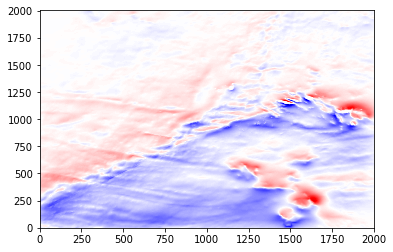

In [27]:
plt.pcolormesh(pn.imag.T,vmin=-2,vmax=2,cmap="seismic")

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


Lk = 4.67e+02, kernel size (406,406) timing: 3.3519129999999677 3.353325843811035
Lk = 2.89e+02, kernel size (250,250) timing: 2.847437999999954 2.8515658378601074
Lk = 1.79e+02, kernel size (154,154) timing: 2.3895820000000185 2.389603853225708
Lk = 1.11e+02, kernel size (96,96) timing: 1.9626069999999913 1.962850570678711
Lk = 6.83e+01, kernel size (58,58) timing: 1.8398990000000026 1.8389270305633545
Lk = 4.23e+01, kernel size (36,36) timing: 1.8927499999999782 1.892199993133545
Lk = 2.61e+01, kernel size (22,22) timing: 1.9132510000000025 1.911952257156372
Lk = 1.62e+01, kernel size (14,14) timing: 2.1308250000000157 2.129523515701294
Lk = 1.00e+01, kernel size (8,8) timing: 1.7209520000000111 1.7191095352172852


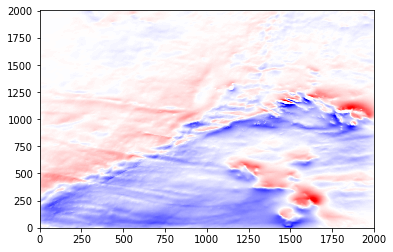

In [29]:
omega = K1
imod = 1
nks = 10

indox, indoy = np.where(h_ma>-zmin)
trunc = 4.1 # truncature (K0(4.1) = 1/100)

cn = cn_expN(imod,h_ma,omega/3600.)
kn = np.sqrt(fcor**2-omega**2)/cn/3600
kmin = np.nanmin(kn[h_t<zmin])
kmax = np.nanmax(kn[h_t<zmin])
#ks = np.linspace(kmin,kmax,nks)
ks = np.logspace(np.log10(kmin),np.log10(kmax),nks)

udhx, vdhy = ue*dhdx, ve*dhdy
pn = np.zeros((Nx,Ny)) + 0.j

k2 = kmin
nsx = min(int(trunc/kk/dx)//2 * 2, Nx//2)
nsy = min(int(trunc/kk/dy)//2 * 2, Ny//2)
xp, yp = np.arange(-nsx+0.5,nsx)*dx, np.arange(-nsy+0.5,nsy)*dy
rad = np.sqrt(xp[:,None]**2 + yp[None,:]**2)
kern = sp.kn(0,k2*rad)
kern[rad*k2 > trunc] = 0
solb = sig.fftconvolve(udhx, kern, mode="same") + sig.fftconvolve(vdhy, kern, mode = "same")

for ik in range(1,nks):
    k1, k2 = ks[ik-1:ik+1]
    sola = solb.copy()
    mask = np.where( (kn>=k1) & (kn<k2) )
    nsx = min(int(trunc/k2/dx)//2 * 2, Nx//2)
    nsy = min(int(trunc/k2/dy)//2 * 2, Ny//2)
    xp, yp = np.arange(-nsx+0.5,nsx)*dx, np.arange(-nsy+0.5,nsy)*dy
    rad = np.sqrt(xp[:,None]**2 + yp[None,:]**2)
    kern = sp.kn(0,k2*rad)
    kern[rad*k2 > trunc] = 0
    wt = np.array([k2 - kn[mask], kn[mask] - k1]) / (k2 - k1)
    tmes, tmeb = time.clock(), time.time()
    solb = sig.fftconvolve(udhx, kern, mode="same") + sig.fftconvolve(vdhy, kern, mode = "same")
    print("Lk = {0:.2e}, kernel size ({1},{2})".format(2*np.pi/k2/1e3,nsx,nsy) \
            , "timing:", time.clock()-tmes, time.time()-tmeb)
    pn[mask] = wt[0,:]*sola[mask] + wt[1,:]*solb[mask]

pn[kn>=k2] = solb[kn>=k2]

plt.pcolormesh(pn.imag.T,vmin=-2,vmax=2,cmap="seismic")

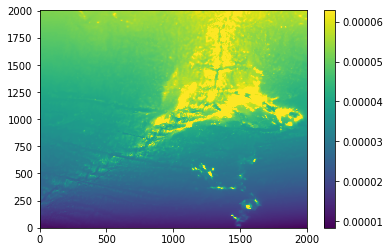

In [11]:
plt.pcolormesh(kn.T,vmax=k2/10); plt.colorbar()

In [22]:
def mypdf(u,bins):
    ''' compute a normalized pdf '''                                 
    pdf, _ = np.histogram(u,bins)
    pdf = pdf / ((bins[2]-bins[1])*len(u))
    return pdf

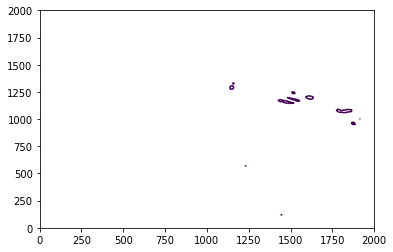

In [70]:
plt.contour(h_t.T,levels=[-100])

In [50]:
omega

0.2625652029744917